# Activity Classifier

In this notebook, we build a CNN neural net to classify PE activity. We use demographic data as well as the ecceleration data

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, Concatenate , Input
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPool1D,AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score as score

import os 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


# Visiualization imports, Netron and tensorboard:
import netron
import seaborn as sns
from datetime import datetime
from packaging import version
from tensorflow import keras


In [2]:
# Try to get reproducable results
from numpy.random import seed
seed(85)
from tensorflow.random import set_seed
set_seed(75)

#### Set hyperparameters

In [3]:
# output directory name:
output_dir = 'model_output/demographic-cnn'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency



n_dense_2= 512
n_dense_1= 512
n_conv_3= 256
n_conv_2= 512
n_conv_1= 512
maxpooling_pool_size= 2
k_conv_3= 2
k_conv_2= 2
k_conv_1= 2
dropout_2= 0.2
dropout_1= 0.2
avepooling_pool_size= 2
activation_dense = 'relu'
activation_conv = 'relu'


# training:
epochs = 120
batch_size = 256

#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
raw_data['metadata'][2]

array([164.,  68.,  30.,   0.])

In [6]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
accel_input_shape = list(accel_array.shape)
meta_input_shape = list(meta_array.shape)


#### Preprocess data

### Data preparation 
1- Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>

2- Standardize the demographic data
3- Split and shuffle



In [7]:
lb = LabelBinarizer()
y = lb.fit_transform(labels_array)
n_class = len(lb.classes_)
class_list = lb.classes_

In [8]:
sc = StandardScaler()
meta_array = sc.fit_transform(meta_array)

In [9]:
X_train_index, X_valid_index, y_train, y_valid = train_test_split(
     (np.arange(len(accel_array))), y, test_size=0.1, random_state=65)
X_accel_train = accel_array[X_train_index]
X_accel_valid = accel_array[X_valid_index]
X_meta_train = meta_array[X_train_index]
X_meta_valid = meta_array[X_valid_index]





#### Design neural network architecture using functional API

In [10]:
accel_input = Input(shape=accel_input_shape[1:], name="Acceleration-data")
meta_input = Input(shape=meta_input_shape[1:], name="Demographic-data")
x = Conv1D(n_conv_1, k_conv_1, activation=activation_conv)(accel_input)
x = MaxPool1D(pool_size = maxpooling_pool_size)(x)
x = Conv1D(n_conv_2, k_conv_2, activation=activation_conv)(x)
x = AveragePooling1D(pool_size = avepooling_pool_size)(x)
x = Conv1D(n_conv_2, k_conv_2, activation=activation_conv)(x)
x = GlobalAveragePooling1D()(x)
meta_input_x = Flatten()(meta_input)
x = Concatenate()([x,meta_input_x])

x = Dense(n_dense_1, activation=activation_dense)(x)
x = Dropout(dropout_1)(x)
x = Dense(n_dense_2, activation=activation_dense)(x)
x = Dropout(dropout_2)(x)



output = Dense(n_class, activation='softmax')(x)
     
model = Model(inputs=[accel_input, meta_input], outputs=output, name='biInput')
model.summary()

Model: "biInput"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Acceleration-data (InputLayer)  [(None, 90, 3)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 89, 512)      3584        Acceleration-data[0][0]          
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 44, 512)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 43, 512)      524800      max_pooling1d[0][0]              
____________________________________________________________________________________________

#### Configure model

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [12]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [13]:
model.fit(x=[X_accel_train, X_meta_train], y=y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=([X_accel_valid, X_meta_valid], y_valid), 
          callbacks=[modelcheckpoint])


Epoch 1/120
228/228 [==============================] - 11s 50ms/step - loss: 0.9853 - accuracy: 0.5945 - val_loss: 0.8261 - val_accuracy: 0.6472
Epoch 2/120
228/228 [==============================] - 11s 47ms/step - loss: 0.5245 - accuracy: 0.8023 - val_loss: 0.3677 - val_accuracy: 0.8661
Epoch 3/120
228/228 [==============================] - 11s 47ms/step - loss: 0.3558 - accuracy: 0.8728 - val_loss: 0.2648 - val_accuracy: 0.9126
Epoch 4/120
228/228 [==============================] - 11s 47ms/step - loss: 0.2614 - accuracy: 0.9140 - val_loss: 0.1913 - val_accuracy: 0.9387
Epoch 5/120
228/228 [==============================] - 11s 48ms/step - loss: 0.2065 - accuracy: 0.9335 - val_loss: 0.1728 - val_accuracy: 0.9432
Epoch 6/120
228/228 [==============================] - 11s 47ms/step - loss: 0.1789 - accuracy: 0.9418 - val_loss: 0.1560 - val_accuracy: 0.9477
Epoch 7/120
228/228 [==============================] - 11s 48ms/step - loss: 0.1722 - accuracy: 0.9451 - val_loss: 0.1424 - val_ac

228/228 [==============================] - 11s 48ms/step - loss: 0.0363 - accuracy: 0.9872 - val_loss: 0.1167 - val_accuracy: 0.9683
Epoch 56/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0329 - accuracy: 0.9888 - val_loss: 0.1202 - val_accuracy: 0.9697
Epoch 57/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0315 - accuracy: 0.9888 - val_loss: 0.1235 - val_accuracy: 0.9708
Epoch 58/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0372 - accuracy: 0.9874 - val_loss: 0.1142 - val_accuracy: 0.9736
Epoch 59/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0308 - accuracy: 0.9889 - val_loss: 0.1156 - val_accuracy: 0.9724
Epoch 60/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0284 - accuracy: 0.9899 - val_loss: 0.1143 - val_accuracy: 0.9728
Epoch 61/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0315 - accuracy: 0.9894 - val_loss: 0.1180 - val_accuracy

228/228 [==============================] - 11s 48ms/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.1340 - val_accuracy: 0.9736
Epoch 112/120
228/228 [==============================] - 11s 47ms/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.1232 - val_accuracy: 0.9747
Epoch 113/120
228/228 [==============================] - 11s 47ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 0.1414 - val_accuracy: 0.9727
Epoch 114/120
228/228 [==============================] - 11s 47ms/step - loss: 0.0224 - accuracy: 0.9923 - val_loss: 0.1408 - val_accuracy: 0.9759
Epoch 115/120
228/228 [==============================] - 11s 48ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 0.1256 - val_accuracy: 0.9756
Epoch 116/120
228/228 [==============================] - 11s 47ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.1347 - val_accuracy: 0.9754
Epoch 117/120
228/228 [==============================] - 11s 47ms/step - loss: 0.0178 - accuracy: 0.9935 - val_loss: 0.1271 - val_ac

#### Evaluate

In [26]:
model.load_weights(output_dir+"/weights.91.hdf5") # 97.70

In [27]:
y_hat = model.predict([X_accel_valid, X_meta_valid])

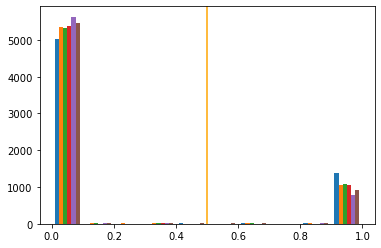

In [28]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

#### Histogram of probabilities for each class
If most probabilities are around either zero or one, it means the model was confidant in classification

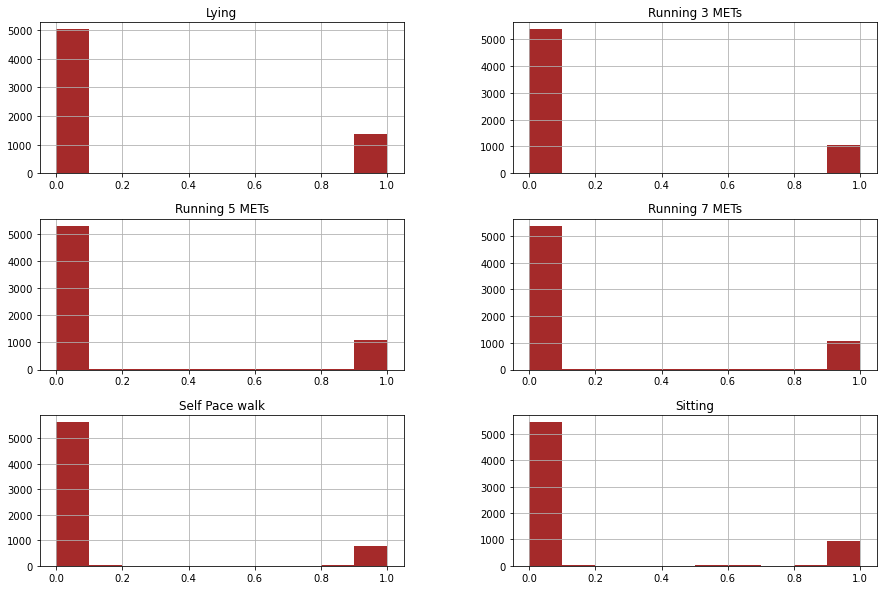

In [29]:
df = pd.DataFrame(y_hat, columns=class_list)
_ = df.hist(figsize=(15,10), color='brown')

In [30]:

# Calculate ROC and Accuracy
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100

In [31]:

print("The model accuracy is: {:0.2f}".format(acc))
print("The area under ROC curve is: {:0.2f}".format(pct_auc))

The model accuracy is: 97.58
The area under ROC curve is: 99.87


#### plot confusion matrix
First use seaborn, then a custom stript.

In [32]:
# convert probability to class
y_pred_class = np.argmax(y_hat, axis=1)
y_class = np.argmax(y_valid, axis = 1)

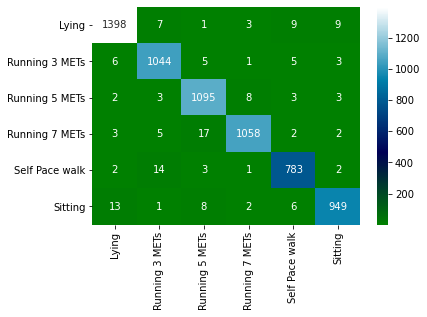

In [33]:
# Create confucion matrix:
cf_matrix = confusion_matrix(y_class, y_pred_class, labels=range(len(class_list)))


# the classes are not in order, for example 'sitting' is not following 'lying'. Sort them:

confusion_matrix_df = pd.DataFrame(cf_matrix, index=class_list, columns=class_list)
confusion_matrix_df = confusion_matrix_df[['Lying','Sitting', 'Self Pace walk',\
                                           'Running 3 METs','Running 5 METs', 'Running 7 METs']]
confusion_matrix_df = confusion_matrix_df.reindex(['Lying', 'Sitting', 'Self Pace walk',\
                                                   'Running 3 METs','Running 5 METs', 'Running 7 METs'])
_ = sns.heatmap(cf_matrix, annot=True, fmt = '1', xticklabels=class_list, yticklabels=class_list, cmap='ocean')


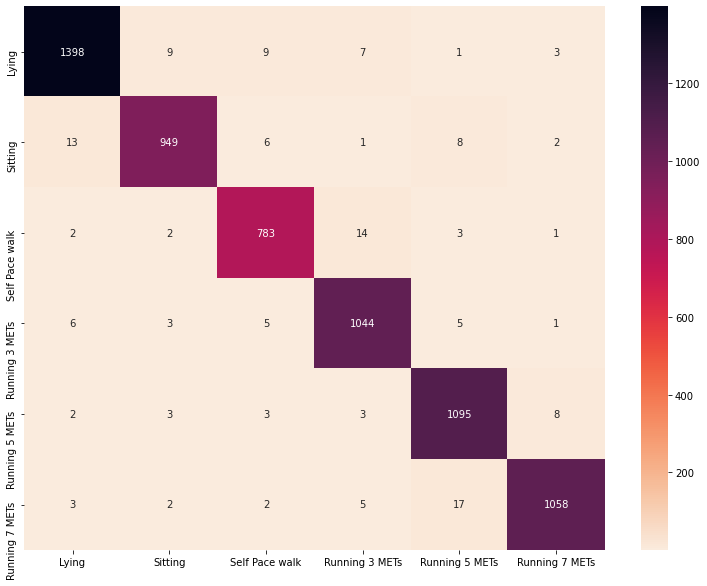

In [34]:
plt.figure(figsize = (13,10))

_ = sns.heatmap(confusion_matrix_df, annot=True, fmt = '1', cmap='rocket_r') # try cmap='rocket', 'PuBuGn', 'magma'

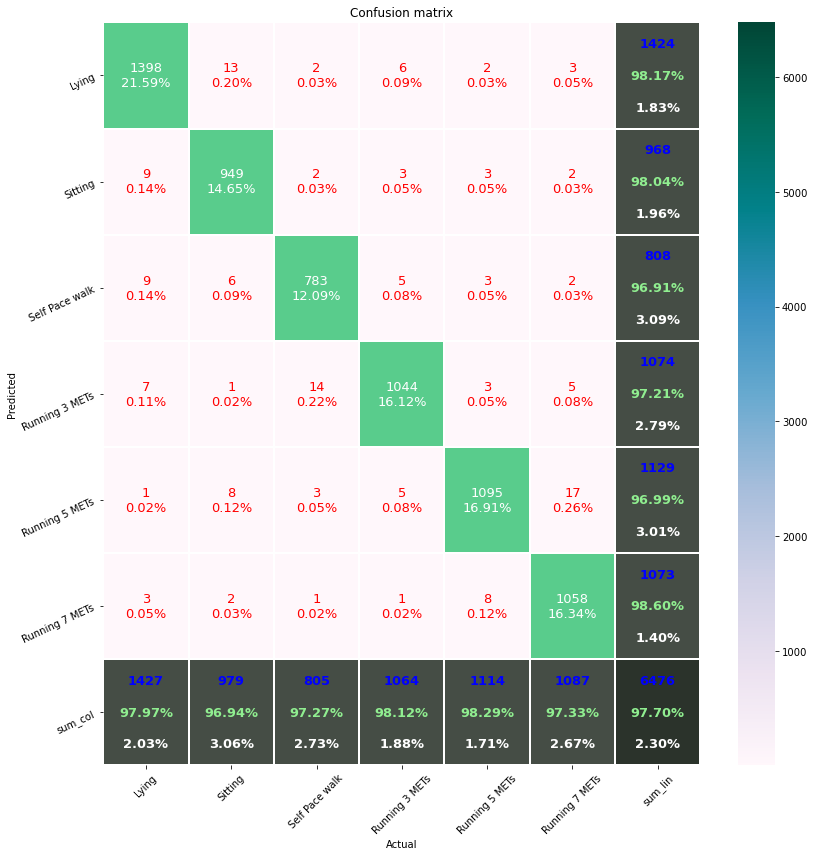

In [35]:
import prettyconfusion as pf
pf.pretty_plot_confusion_matrix(confusion_matrix_df,cmap='PuBuGn', cbar='oranges'
                                ,fz = 13, lw=1, figsize=[12,12])

In [25]:
# All stored weights have the same structure. Load one of them to netron and save the image 
netron.start(file=output_dir+"/weights.01.hdf5")

Serving 'model_output/demographic-cnn/weights.01.hdf5' at http://localhost:8080
